# Assignment 2
## Simen Nygard MTFYMA

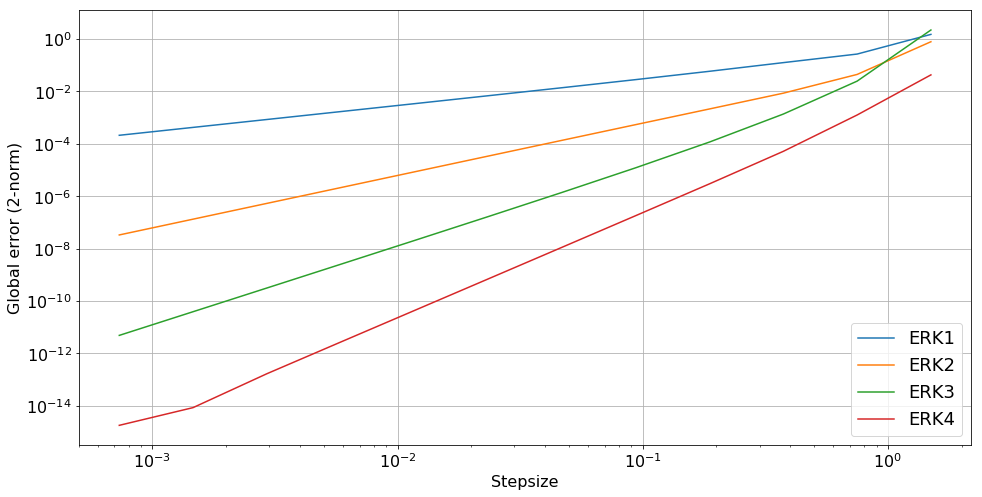

In [11]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from functools import wraps
%matplotlib inline

mpl.rcParams.update({'axes.grid': True, 'legend.fontsize': 18, 'legend.handlelength': 2,
                     'axes.labelsize': 16, 'axes.titlesize': 18, 'figure.figsize': (16, 8),
                    'font.size':16})

def memoize(func):
    func.cache= {}

    @wraps(func)
    def memoized_func(*args, **kwargs):
        key = args[-1]

        if key in func.cache:
            ret=func.cache[key]
        else:
            ret=func.cache[key] = func(*args, **kwargs)

        if len(func.cache) == len(args[1]): #last K isn't used in any other K, and we can empty the cache for the current y
            func.cache = {} #
        return ret

    return memoized_func

def f(y):
    du = y[0] - 2 * y[0] * y[1]
    dv = -y[1] + 3 * y[0] * y[1]
    return np.array([du, dv])

dt = lambda k: tf/2 ** (k)

@memoize
def K(y, A, h, i):
    if len(A)==1: #Cannot index a single element as A[i,j] on single element
        return f(y)
    else:
        return f(y + h * sum(0 if not A[i, j] else A[i, j] * K(y, A, h, j) for j in range(i + 1)))  # Assumes explicit A


def F(y, A, b, h):
    return sum(b[i] * K(y, A, h, i) for i in range(len(A)))


def RKStep(y, A, b, h):
    y += h * F(y, A, b, h)
    return y


def simulation():

    b = np.array([np.array(arr) for arr in ([1],
                                           [1/2, 1/2],
                                           [1 / 6, 2 / 3, 1 / 6],
                                           [1 / 6, 1 / 3, 1 / 3, 1 / 6])])

    A = np.array([np.array(arr) for arr in ([0],
                                            [[0, 0], [1, 0]],
                                            [[0, 0, 0], [1 / 2, 0, 0], [-1, 2, 0]],
                                            [[0, 0, 0, 0], [1 / 2, 0, 0, 0], [0, 1 / 2, 0, 0], [0, 0, 1, 0]])])

    def curry(y, A=A[3], b=b[3], h=0.1 * dt(Ne)):
        return RKStep(y, A, b, h)

    yex = y0.copy()
    for i in range(10*2**Ne):
        yex = curry(yex)

    ERR = np.empty((4, Ne))

    for k in range(Ne):
        y = np.stack(y0 for _ in range(4))
        h = dt(k + 1)
        for j in range(2**(k+1)):
            for i in range(4):
                y[i] = RKStep(y[i], A[i], b[i], h)

        ERR[:, k] = np.linalg.norm(y - yex,2, axis=1)

    return ERR


def visualiation(err):
    plt.loglog(dt(np.arange(1, Ne + 1)), err.T)
    plt.legend(plt.gca().lines, ('ERK%d' % i for i in range(1, 5)))
    plt.xlabel('Stepsize')
    plt.ylabel('Global error (2-norm)')
    plt.show()


def main():
    visualiation(simulation())
    

if __name__ == "__main__":
    y0 = np.array([1 / 3, 1])
    tf = 3
    Ne = 12
    main()

Letting the solution given by ERK4 with stepsize $h=0.1 \ t_f \ 2^{-N_e}$ be our reference, we see that the global error commited with the ERK-methods are $\mathcal{O}(h^p)$. We mostly stay below this upper bound; ERK4 commits an error of $10^{-14}<10^{-12}$ for a stepsize $h=10^{-3}$.  The other methods tell the same story; the error increases by approximately $1/h$ for every decrease in method order. The global error naturally increases with increasing stepsize in all cases, owing to rougher approximations of the derivatives yielding worse approximations of the solution. As $h$ increases, the methods yield errors of more similar sizes. Trying to approximate the derivative with multiple function evaluations ends up being just as bad as using fewer evaluations when the points evaluated are too far spread apart.   